In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

import warnings
import pandas as pd
import pickle

from tqdm import tqdm
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from pathlib import Path
base_path = os.path.join(os.path.dirname(os.getcwd()))
print(f"Base path: {base_path}")
data_path = Path(base_path, "data", "bepro", "processed")
yaml_file = Path(base_path, "assertion", "transitions.yaml")

from assertion.bepro import convert_to_actions
from assertion.validator import Validator

Base path: /root/express-v2


In [2]:
match_id_lst = os.listdir(data_path)
print(match_id_lst)
match_id = match_id_lst[0]  # Change this to the desired match ID
match_id = "126306"

['126424', '126364', '126332', '153387', '126386', '126306', '126380', '126401', '126356', '126433', '126458', '126476', '126309', '126341', '153390', '126473', '153364', '126391', '126444', '153379', '126350', '126315', '153385', '126466', '126285', '126429', '126293', '126298', '126411', '153373', '126448', '126367', '126418', '126348', '126455', '126325', '126408', '126319', '126378', '153381']


In [3]:
with open(f"{data_path}/{match_id}/{match_id}_processed_dict.pkl", "rb") as f:
    match_dict = pickle.load(f)
    
    events = match_dict['event_df']
    teams_dict = match_dict['teams']
    metadata = match_dict['meta_data']
    tracking_df = match_dict['tracking_df']

pd.concat([events.groupby("period_order").head(1), 
           events.groupby("period_order").tail(1)])

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction
0,Half,1st Half,0,2700000,0,2033,Daegu FC,5,Kyohei Yoshino,"[{'event_name': 'Passes', 'property': {'Outcom...",0.496900,0.510900,0.660000,0.474000,LEFT
0,Half,2nd Half,1,2700000,2700000,2702421,Gwangju FC,20,Kunhee Lee,"[{'event_name': 'Passes', 'property': {'Outcom...",0.500400,0.501900,0.519400,0.510900,LEFT
2138,Half,1st Half,0,2700000,0,2955500,Daegu FC,2,Jaewon Hwang,"[{'name': 'HIR', 'property': {'duration': 4500...",0.307967,0.682117,0.424779,0.431853,LEFT
2200,Half,2nd Half,1,2700000,2700000,5717000,Gwangju FC,99,Beka Mikeltadze,"[{'name': 'SPRINT', 'property': {'duration': 1...",0.131620,0.507341,0.050954,0.564573,LEFT


In [4]:
teams_df = pd.concat([teams_dict["Home"], teams_dict["Away"]], ignore_index=True)
player_name_to_player_id = {row.player: int(row.pID) for row in teams_df.itertuples()}
player_id_to_team_id = {int(row.pID): int(row.tID) for row in teams_df.itertuples()}
player_id_to_team = {int(row.pID): row.team for row in teams_df.itertuples()}

events["game_id"] = match_id
events["event_id"] = range(len(events))
events["player_id"] = events["player_name"].map(player_name_to_player_id).astype(int)
events["team_id"] = events["player_id"].map(player_id_to_team_id).astype(int)
events["team"] = events["player_id"].map(player_id_to_team)
events

,period_type,period_name,period_order,period_duration,period_start_time,event_time,team_name,player_shirt_number,player_name,events,x,y,to_x,to_y,attack_direction,game_id,event_id,player_id,team_id,team
0,Half,1st Half,0,2700000,0,2033,Daegu FC,5,Kyohei Yoshino,"[{'event_name': 'Passes', 'property': {'Outcom...",0.496900,0.510900,0.660000,0.474000,LEFT,126306,0,500505,4644,Away
1,Half,1st Half,0,2700000,0,3000,Gwangju FC,10,Huigyun Lee,"[{'name': 'VHIR', 'property': {'duration': 150...",0.532038,0.608625,0.611812,0.533458,RIGHT,126306,1,77414,4648,Home
2,Half,1st Half,0,2700000,0,3000,Daegu FC,11,Cesinha,"[{'name': 'VHIR', 'property': {'duration': 250...",0.432307,0.299442,0.305536,0.363754,LEFT,126306,2,62112,4644,Away
3,Half,1st Half,0,2700000,0,3267,Daegu FC,20,Gangsan Kim,"[{'event_name': 'Passes Received', 'property':...",0.660000,0.474000,NaN,NaN,LEFT,126306,3,342719,4644,Away
4,Half,1st Half,0,2700000,0,3500,Daegu FC,9,Edgar,"[{'name': 'VHIR', 'property': {'duration': 200...",0.454527,0.927942,0.349684,0.913900,LEFT,126306,4,62114,4644,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,Half,2nd Half,1,2700000,2700000,5715500,Daegu FC,6,Myeongseok Go,"[{'name': 'VHIR', 'property': {'duration': 150...",0.174570,0.536900,0.098605,0.496975,RIGHT,126306,4335,500520,4644,Away
2197,Half,2nd Half,1,2700000,2700000,5715500,Gwangju FC,7,Jisung Eom,"[{'name': 'SPRINT', 'property': {'duration': 2...",0.148533,0.324108,0.025722,0.389061,LEFT,126306,4336,188178,4648,Home
2198,Half,2nd Half,1,2700000,2700000,5716400,Daegu FC,33,Chul Hong,"[{'name': 'VHIR', 'property': {'duration': 200...",0.129817,0.695654,0.018652,0.636774,RIGHT,126306,4337,250076,4644,Away
2199,Half,2nd Half,1,2700000,2700000,5716537,Gwangju FC,18,Yool Heo,"[{'event_name': 'Shots & Goals', 'property': {...",0.121300,0.386400,NaN,NaN,LEFT,126306,4338,145703,4648,Home


In [5]:
actions = convert_to_actions(events)
actions

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126306.0,0,0.0,1.0,2.033,3.267,4644.0,500505.0,342719.0,-1.0,...,38.0,Successful,3.0,-1.0,52.1745,34.7412,69.3000,32.2320,17.1255,-2.5092
1,126306.0,3,1.0,1.0,3.267,NaN,4644.0,342719.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,69.3000,32.2320,69.3000,32.2320,0.0000,0.0000
2,126306.0,7,2.0,1.0,4.800,7.033,4644.0,342719.0,62086.0,-1.0,...,38.0,Successful,8.0,-1.0,67.1790,33.7484,78.3405,56.4740,11.1615,22.7256
3,126306.0,8,3.0,1.0,7.033,NaN,4644.0,62086.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,78.3405,56.4740,78.3405,56.4740,0.0000,0.0000
4,126306.0,10,4.0,1.0,9.000,11.300,4644.0,62086.0,62114.0,-1.0,...,38.0,Successful,19.0,-1.0,72.8385,56.0592,24.6330,47.1104,-48.2055,-8.9488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,126306.0,4327,2454.0,2.0,3010.385,3011.907,4648.0,500133.0,62365.0,-1.0,...,38.0,Successful,4330.0,-1.0,58.3590,50.2520,52.2060,34.5372,-6.1530,-15.7148
2455,126306.0,4330,2455.0,2.0,3011.907,NaN,4648.0,62365.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,52.2060,34.5372,52.2060,34.5372,0.0000,0.0000
2456,126306.0,4332,2456.0,2.0,3014.879,3016.537,4648.0,62365.0,145703.0,-1.0,...,38.0,Successful,4338.0,-1.0,63.4410,29.5664,92.2635,41.7248,28.8225,12.1584
2457,126306.0,4338,2457.0,2.0,3016.537,NaN,4648.0,145703.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,92.2635,41.7248,92.2635,41.7248,0.0000,0.0000


In [6]:
validator = Validator(actions, yaml_file)
validator.validate_sequence()
valid_events = validator.df_events
valid_events

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126306.0,0,0,1.0,2.033,3.267,4644.0,500505.0,342719.0,-1.0,...,38.0,Successful,3.0,-1.0,52.1745,34.7412,69.3000,32.2320,17.1255,-2.5092
1,126306.0,3,1,1.0,3.267,NaN,4644.0,342719.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,69.3000,32.2320,69.3000,32.2320,0.0000,0.0000
2,126306.0,7,2,1.0,4.800,7.033,4644.0,342719.0,62086.0,-1.0,...,38.0,Successful,8.0,-1.0,67.1790,33.7484,78.3405,56.4740,11.1615,22.7256
3,126306.0,8,3,1.0,7.033,NaN,4644.0,62086.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,78.3405,56.4740,78.3405,56.4740,0.0000,0.0000
4,126306.0,NaN,4,1.0,7.034,NaN,4644.0,62086.0,NaN,-1.0,...,28.0,NaN,NaN,NaN,78.3405,56.4740,72.8385,56.0592,-5.5020,-0.4148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,126306.0,4330,3116,2.0,3011.907,NaN,4648.0,62365.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,52.2060,34.5372,52.2060,34.5372,0.0000,0.0000
3117,126306.0,NaN,3117,2.0,3011.908,NaN,4648.0,62365.0,NaN,-1.0,...,28.0,NaN,NaN,NaN,52.2060,34.5372,63.4410,29.5664,11.2350,-4.9708
3118,126306.0,4332,3118,2.0,3014.879,3016.537,4648.0,62365.0,145703.0,-1.0,...,38.0,Successful,4338.0,-1.0,63.4410,29.5664,92.2635,41.7248,28.8225,12.1584
3119,126306.0,4338,3119,2.0,3016.537,NaN,4648.0,145703.0,-1.0,-1.0,...,22.0,NaN,-1.0,-1.0,92.2635,41.7248,92.2635,41.7248,0.0000,0.0000


In [7]:
validator.df_errors

,game_id,event_id,current_state,next_state,event,error
0,126306.0,8.0,in_possession,in_possession,Carry,Dribble Add
1,126306.0,NaN,post_shot,set_piece,Out,Resolved
2,126306.0,26.0,in_possession,in_possession,Carry,Dribble Add
3,126306.0,28.0,in_possession,in_possession,Carry,Dribble Add
4,126306.0,31.0,in_possession,in_possession,Carry,Dribble Add
...,...,...,...,...,...,...
754,126306.0,4295.0,in_possession,in_possession,Carry,Dribble Add
755,126306.0,4313.0,in_possession,in_possession,Carry,Dribble Add
756,126306.0,4324.0,in_possession,in_possession,Carry,Dribble Add
757,126306.0,4326.0,in_possession,in_possession,Carry,Dribble Add


In [8]:
import assertion.config as lsdpconfig

PITCH_X_MIN, PITCH_X_MAX = -52.5, 52.5
PITCH_Y_MIN, PITCH_Y_MAX = -34.0, 34.0

valid_events_filtered = valid_events.copy()

for col in ["start_x", "end_x"]:
    valid_events_filtered[col] += PITCH_X_MIN
for col in ["start_y", "end_y"]:
    valid_events_filtered[col] += PITCH_Y_MIN

valid_events_filtered["type_name"] = valid_events_filtered["type_name"].map(lsdpconfig.versa_to_spadl_dict)
valid_events_filtered = valid_events_filtered[valid_events_filtered["type_name"] != "non_action"].reset_index(drop=True)
valid_events_filtered["type_id"] = valid_events_filtered["type_name"].apply(lambda t: lsdpconfig.spadl_actiontypes.index(t))
valid_events_filtered

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126306.0,0,0,1.0,2.033,3.267,4644.0,500505.0,342719.0,-1.0,...,2,Successful,3.0,-1.0,-0.3255,0.7412,16.8000,-1.7680,17.1255,-2.5092
1,126306.0,3,1,1.0,3.267,NaN,4644.0,342719.0,-1.0,-1.0,...,3,NaN,-1.0,-1.0,16.8000,-1.7680,16.8000,-1.7680,0.0000,0.0000
2,126306.0,7,2,1.0,4.800,7.033,4644.0,342719.0,62086.0,-1.0,...,2,Successful,8.0,-1.0,14.6790,-0.2516,25.8405,22.4740,11.1615,22.7256
3,126306.0,8,3,1.0,7.033,NaN,4644.0,62086.0,-1.0,-1.0,...,3,NaN,-1.0,-1.0,25.8405,22.4740,25.8405,22.4740,0.0000,0.0000
4,126306.0,NaN,4,1.0,7.034,NaN,4644.0,62086.0,NaN,-1.0,...,5,NaN,NaN,NaN,25.8405,22.4740,20.3385,22.0592,-5.5020,-0.4148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2774,126306.0,4330,3116,2.0,3011.907,NaN,4648.0,62365.0,-1.0,-1.0,...,3,NaN,-1.0,-1.0,-0.2940,0.5372,-0.2940,0.5372,0.0000,0.0000
2775,126306.0,NaN,3117,2.0,3011.908,NaN,4648.0,62365.0,NaN,-1.0,...,5,NaN,NaN,NaN,-0.2940,0.5372,10.9410,-4.4336,11.2350,-4.9708
2776,126306.0,4332,3118,2.0,3014.879,3016.537,4648.0,62365.0,145703.0,-1.0,...,2,Successful,4338.0,-1.0,10.9410,-4.4336,39.7635,7.7248,28.8225,12.1584
2777,126306.0,4338,3119,2.0,3016.537,NaN,4648.0,145703.0,-1.0,-1.0,...,3,NaN,-1.0,-1.0,39.7635,7.7248,39.7635,7.7248,0.0000,0.0000


In [9]:
import numpy as np

tracking_df["time"] = (tracking_df["timestamp"].dt.total_seconds()).astype(float)
tracking_df["time"] = np.where(
    tracking_df["period_id"] == 1,
    tracking_df["time"],
    tracking_df["time"] - 2700
)

pd.concat([tracking_df.groupby("period_id").head(1), tracking_df.groupby("period_id").tail(1)]).sort_values("period_id")

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,...,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier,time
0,126306,1.0,0 days 00:00:02.200000,55,alive,4644,-22.383857,21.022300,0.0,-0.097138,...,0.309057,-0.207843,0.0,0.372445,145701,4648,LB,4644,False,2.20
1697288,126306,1.0,0 days 00:49:14,73850,alive,neutral,-53.896716,1.384299,0.0,63.412311,...,859.325361,174.062040,0.0,13.500000,ball,ball,ball,4648,False,2954.00
1697289,126306,2.0,0 days 00:45:00,67500,alive,4648,12.193821,-13.251400,0.0,-0.033182,...,0.000000,0.000000,0.0,0.000000,145701,4648,LB,4648,False,0.00
3431738,126306,2.0,0 days 01:35:16.520000,142913,alive,4648,-39.531130,-7.625044,0.0,-17.139984,...,4.049752,1.701565,0.0,4.392700,ball,ball,ball,4648,False,3016.52


In [10]:
team_sheets = pd.concat([teams_dict["Home"], teams_dict["Away"]], ignore_index=True)
team_sheets["pID"] = team_sheets["pID"].astype(int)
team_sheets["tID"] = team_sheets["tID"].astype(int)
team_sheets

,player,position,team,jID,pID,tID,xID
0,Kyeongmin Kim,GK,Home,1,250079,4648,0
1,Mingi Lee,LB,Home,3,145701,4648,1
2,Alexandar Popovic,CB,Home,4,500133,4648,2
3,Youngkyu Ahn,CB,Home,6,62365,4648,3
4,Hyeonseok Doo,RB,Home,13,62386,4648,4
5,Gabriel,RM,Home,11,500135,4648,5
6,Hoyeon Jeong,CM,Home,14,250101,4648,6
7,Kyongrok Choi,CM,Home,30,500139,4648,7
8,Minseo Moon,LM,Home,88,500136,4648,8
9,Huigyun Lee,CF,Home,10,77414,4648,9


In [11]:
pd.concat([valid_events_filtered.groupby("period_id").head(1), 
           valid_events_filtered.groupby("period_id").tail(1)]).sort_values("period_id")

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
0,126306.0,0,0,1.0,2.033,3.267,4644.0,500505.0,342719.0,-1.0,...,2,Successful,3.0,-1.0,-0.3255,0.7412,16.800,-1.7680,17.1255,-2.5092
1313,126306.0,2134,1487,1.0,2952.933,NaN,4644.0,500505.0,-1.0,-1.0,...,7,Goal,-1.0,-1.0,-35.0175,-3.3184,-52.500,0.0000,-17.4825,3.3184
1314,126306.0,2139,1489,2.0,2.421,3.539,4648.0,250102.0,250101.0,-1.0,...,2,Successful,2141.0,-1.0,-0.0420,-0.1292,-2.037,-0.7412,-1.9950,-0.6120
2778,126306.0,4338,3120,2.0,3016.537,NaN,4648.0,145703.0,-1.0,-1.0,...,7,Off Target,-1.0,-1.0,39.7635,7.7248,52.500,19.9272,12.7365,12.2024


In [14]:
t = 262.8#269.4
valid_events_filtered[(valid_events_filtered["period_id"] == 2) &
                      (valid_events_filtered["time_seconds"] <= t+1)]

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,type_id,result_name,relative_id,pair_id,start_x,start_y,end_x,end_y,dx,dy
1314,126306.0,2139,1489,2.0,2.421,3.539,4648.0,250102.0,250101.0,-1.0,...,2,Successful,2141.0,-1.0,-0.0420,-0.1292,-2.0370,-0.7412,-1.9950,-0.6120
1315,126306.0,2141,1490,2.0,3.539,NaN,4648.0,250101.0,-1.0,-1.0,...,3,NaN,-1.0,-1.0,-2.0370,-0.7412,-2.0370,-0.7412,0.0000,0.0000
1316,126306.0,NaN,1491,2.0,3.540,NaN,4648.0,250101.0,NaN,-1.0,...,5,NaN,NaN,NaN,-2.0370,-0.7412,-3.0240,-3.8420,-0.9870,-3.1008
1317,126306.0,2143,1492,2.0,4.825,NaN,4648.0,250101.0,-1.0,-1.0,...,2,Unsuccessful,-1.0,-1.0,-3.0240,-3.8420,21.5775,9.9348,24.6015,13.7768
1318,126306.0,NaN,1493,2.0,6.633,NaN,4644.0,62086.0,NaN,-1.0,...,11,NaN,NaN,NaN,21.0840,9.5948,21.0840,9.5948,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,126306.0,2329,1625,2.0,259.300,260.700,4644.0,250055.0,62112.0,-1.0,...,2,Successful,2331.0,-1.0,-23.6985,17.9588,-30.4185,19.5160,-6.7200,1.5572
1425,126306.0,2331,1627,2.0,260.700,NaN,4644.0,62112.0,-1.0,-1.0,...,3,NaN,-1.0,2332.0,-30.4185,19.5160,-30.4185,19.5160,0.0000,0.0000
1426,126306.0,NaN,1628,2.0,260.701,NaN,4644.0,62112.0,NaN,-1.0,...,5,NaN,NaN,NaN,-30.4185,19.5160,-35.7630,29.5868,-5.3445,10.0708
1427,126306.0,2333,1629,2.0,262.800,NaN,4644.0,62112.0,-1.0,-1.0,...,2,Unsuccessful,-1.0,-1.0,-35.7630,29.5868,-33.6210,29.3284,2.1420,-0.2584


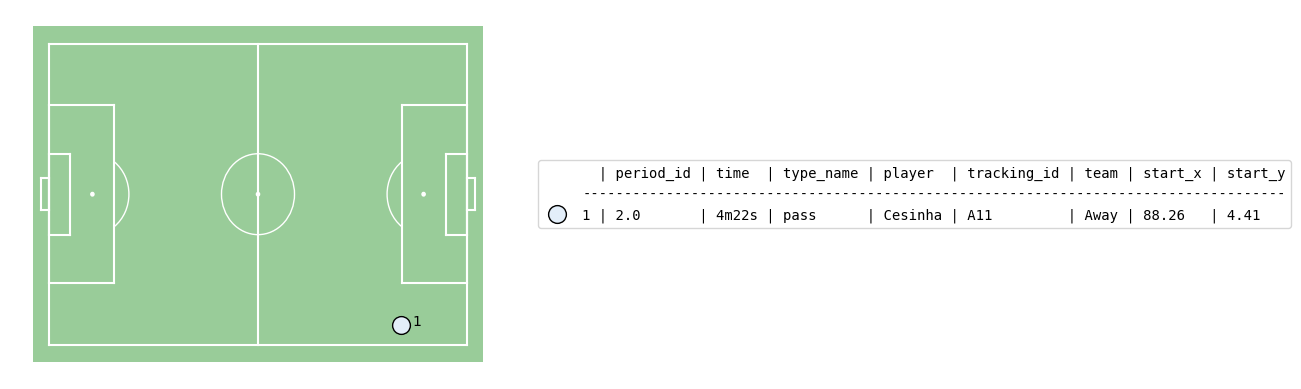

In [19]:
import matplotsoccer as mps

original_event_id = 2333#2336
idx = valid_events_filtered[valid_events_filtered["original_event_id"] == original_event_id].index[0]
e = valid_events_filtered[idx:idx+1].copy()
l = min(1, len(e))

for j in range(0, l):
    row = list(e[j:j+1].itertuples())[0]
    i = row.Index
    a = valid_events_filtered.loc[i-0: i+0].copy()

    a["start_x"] += PITCH_X_MAX
    a["start_y"] += PITCH_Y_MAX
    a["time"] = a["time_seconds"].apply(lambda t: f"{int(t // 60)}m{int(t % 60)}s")

    play_left_to_right = True
    if play_left_to_right:
        a["start_x"] = 105 - a["start_x"]
        a["start_y"] = 68 - a["start_y"]

    for col in ["start_x", "start_y"]:
        a[col] = a[col].apply(lambda x : round(x, 2))

    a = a.merge(team_sheets, left_on="player_id", right_on="pID", how="left")
    a["tracking_id"] = a[["team", "jID"]].apply(lambda x: f"{x['team'][0]}{int(x['jID']):02d}", axis=1)

    cols = ["period_id", "time", "type_name", "player", "tracking_id", "team", "start_x", "start_y"]
    labeltitle = ["period_id", "time", "type_name", "player", "tracking_id", "team", "start_x", "start_y"]

    mps.actions(a[["start_x", "start_y"]],
                a.type_name,
                team=a.team,
                label=a[cols],
                color="green",
                labeltitle = labeltitle,
                zoom=False,
                show=False,
                show_legend= True)

In [16]:
a

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,dy,time,player,position,team,jID,pID,tID,xID,tracking_id
0,126306.0,2333,1629,2.0,262.80,NaN,4644.0,62112.0,-1.0,-1.0,...,-0.2584,4m22s,Cesinha,CF,Away,11,62112,4644,9,A11
1,126306.0,2334,1630,2.0,263.18,NaN,4648.0,188178.0,-1.0,-1.0,...,0.0000,4m23s,Jisung Eom,LM,Home,7,188178,4648,14,H07


In [17]:
team_sheets[team_sheets.pID == 250055.0] 

,player,position,team,jID,pID,tID,xID
28,Jaewon Hwang,RWB,Away,2,250055,4644,8


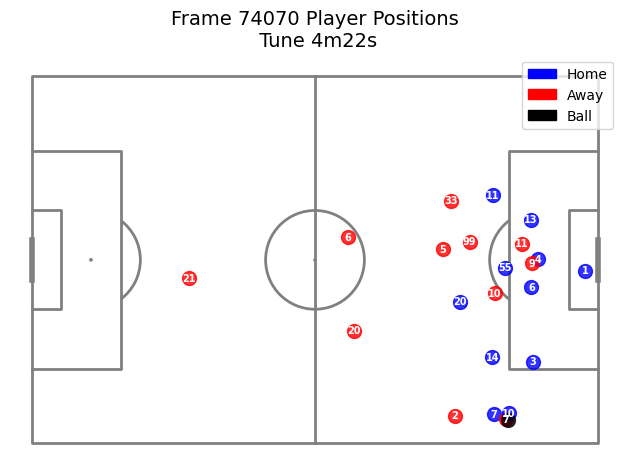

In [18]:
# Visualization

from visualization import plot_single_frame_positions, plot_window_frame_positions

period_id = a.iloc[0].period_id
time_seconds = a.iloc[0].time_seconds
closest_idx = tracking_df[tracking_df["period_id"] == period_id].time.sub(time_seconds).abs().idxmin()

frame = tracking_df.loc[closest_idx]
plot_single_frame_positions(tracking_df, period_id=period_id, time=frame.time, frame_idx=frame.frame_id, home_team_info=teams_dict['Home'], away_team_info=teams_dict['Away'])